# Task 1
Compute the SIFT features of the given image.

a) Extract SIFT features with default parameters and show the keypoints on the image. Hint:
There are existing OpenCV functions you can use for this (see suggestions below).

b) To achieve better visualization of the keypoints, reduce the number of keypoints.
Hint: Vary the parameter contrastThreshold or nfeatures so that the number of keypoints
becomes about 10% of all default keypoints.
Show the result images obtained in a) and b) in your Jupyter notebook and include a brief
description of the approach you used for b).

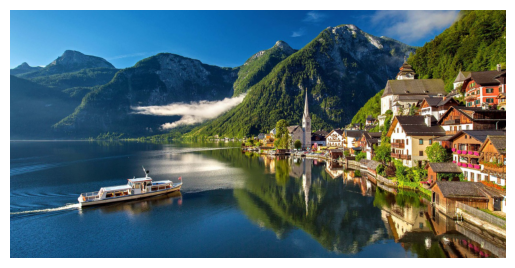

In [96]:
# Part A
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load file
file = 'Hallstatt.png'
img = cv2.imread(file, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(img)


3213


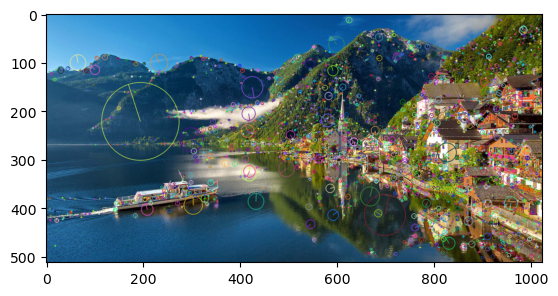

In [97]:
# Get sift points
sift = cv2.SIFT_create()
img2 = img.copy()
kp = sift.detect(img2,None)

img2 = cv2.drawKeypoints(img2,kp,img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(len(kp))
plt.imshow(img2)


322


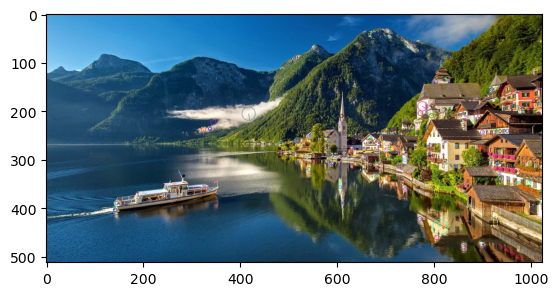

In [98]:
#Reduce to 10% of sift kp
img3 = img.copy()

sift3 = cv2.SIFT_create(nfeatures=int(len(kp)*.1))
kp3 = sift3.detect(img3,None)
img3 = cv2.drawKeypoints(img3,kp3,img3,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(len(kp3))
plt.imshow(img3)


I just took 10% of the number of keypoints generated in part A and made sure that only 10% of those features were generated in b

# Task 2
Distort the image and recompute the SIFT features.

a) Add pepper noise to the given image. Hint: The scikit-image library has a utility function to
add random noise of various types to images.

b) Extract the SIFT features from the noisy image and show the keypoints using the same
parameter setting as for Task 1 (for the reduced number of keypoints).

c) Inspect the keypoints visually: Are the keypoints of the noisy image roughly the same as
those of the original image? What does this imply?

Show the result images obtained in a) and b) in your Jupyter notebook and include your
answers to the questions in c).

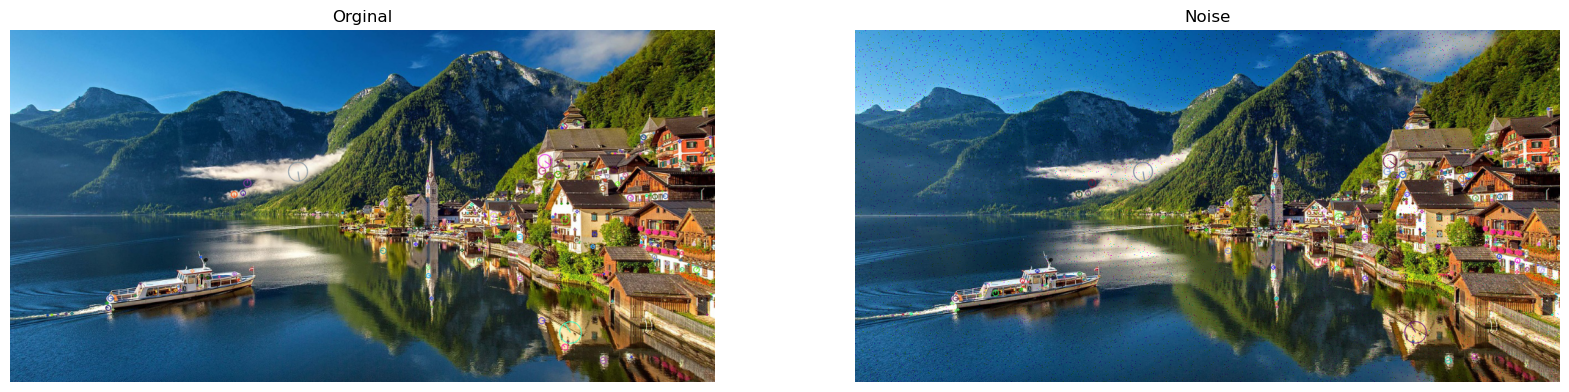

In [99]:
import skimage as ski

imgNoise = ski.util.random_noise(img, mode='pepper', amount=0.01)
imgNoise = ski.img_as_ubyte(imgNoise)
siftT2 = cv2.SIFT_create(nfeatures=int(len(kp)*.1))
kpT2 = siftT2.detect(imgNoise,None)
imgNoise = cv2.drawKeypoints(imgNoise,kpT2,imgNoise,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Display the first image on the left subplot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1), plt.imshow(img3), plt.title('Orginal'), plt.axis('off')

# Display the second image on the right subplot
plt.subplot(1, 2, 2), plt.imshow(imgNoise), plt.title('Noise'), plt.axis('off')
plt.show()




Evidently the SIFT features are effectively identical which proves that SIFT extraction is well resistant to noise.

# Task 3
Transform the image and recompute the SIFT features.

a) Transform the original image by first enlarging it with a scaling factor of 120% and then
rotating the scaled image clockwise by 60 degrees.

b) Extract the SIFT features from the transformed image and show the keypoints using the
same parameter setting as for Task 1 (for the reduced number of keypoints).

c) Inspect the keypoints visually: Are the keypoints of the transformed image roughly the
same as those of the original image? What does this imply?

d) Match the SIFT descriptors of the keypoints of the transformed image with those of the
original image using the nearest-neighbour distance ratio method. Show the keypoints of
the 5 best-matching descriptors on both the original and the transformed image.

Hint: Brute-force matching is available in OpenCV for feature matching. 

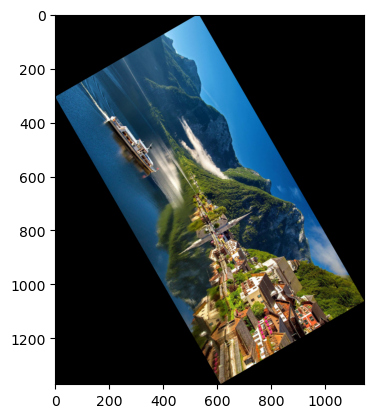

In [100]:
# scaling and rotation
s, r = 1.2, 60

# image dimensions
h, w = img.shape[:2]

# Calculate the center for rotation
c = (w // 2, h // 2)

# Create a transformation matrix for scaling and rotation
M = cv2.getRotationMatrix2D(c, -r, s)

# Calculate the sine and cosine of the angle for rotation
cos_theta = np.abs(M[0, 0])
sin_theta = np.abs(M[0, 1])

# Calculate new dimensions to accommodate the rotated image
new_w = int((h * sin_theta) + (w * cos_theta))
new_h = int((h * cos_theta) + (w * sin_theta))

# Update the rotation matrix to consider resizing
M[0, 2] += (new_w / 2) - (w / 2)
M[1, 2] += (new_h / 2) - (h / 2)

# Apply transformation
imgTrans = cv2.warpAffine(img, M, (new_w, new_h))

plt.imshow(imgTrans)

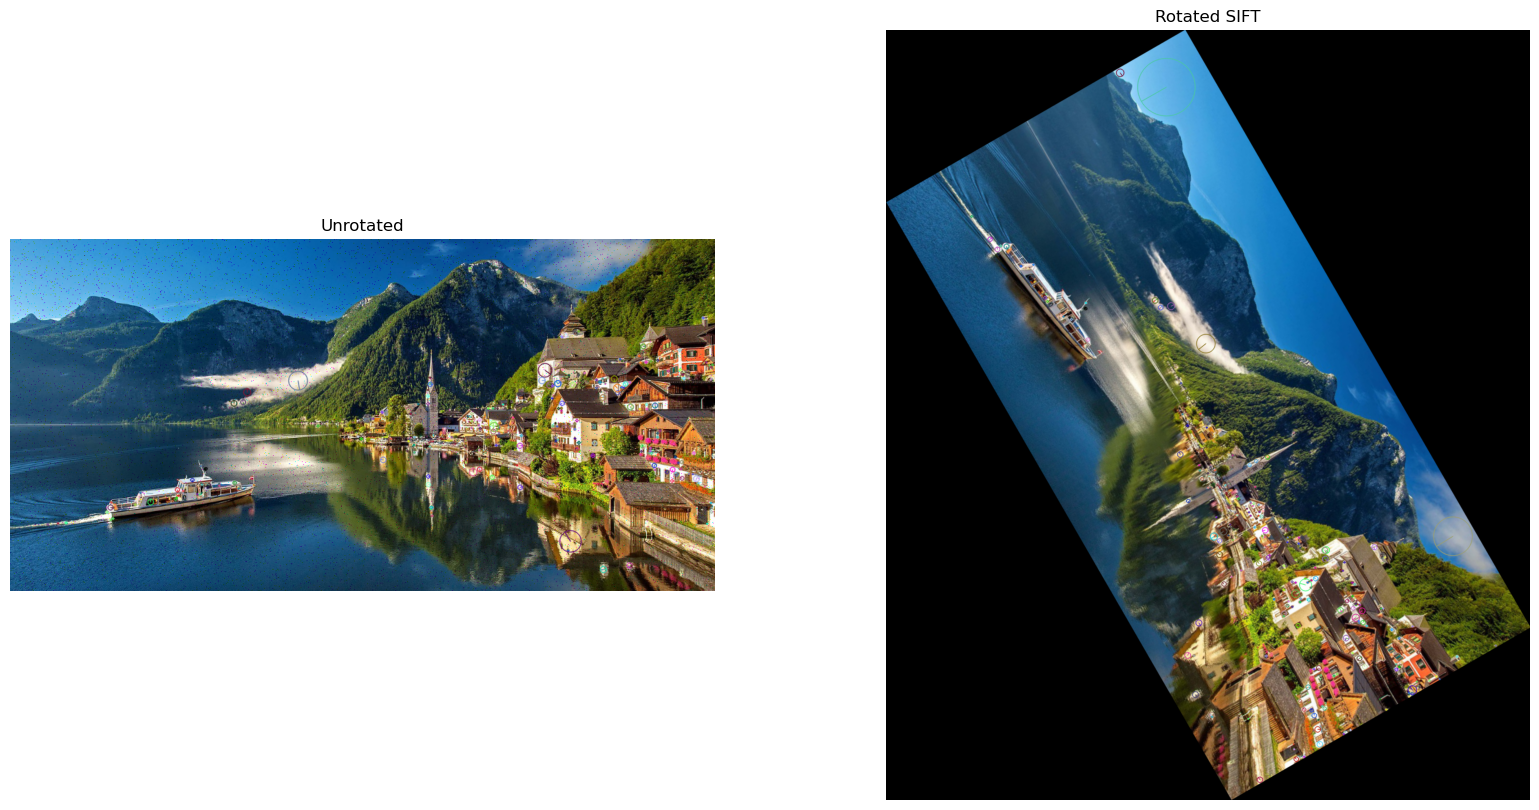

In [101]:
siftT3 = cv2.SIFT_create(nfeatures=int(len(kp)*.1))
kpT2 = siftT3.detect(imgTrans,None)
imgTransSIFT = imgTrans.copy()
imgTransSIFT = cv2.drawKeypoints(imgTransSIFT,kpT2,imgTransSIFT,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Display the first image on the left subplot
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1), plt.imshow(imgNoise), plt.title('Unrotated'), plt.axis('off')

# Display the second image on the right subplot
plt.subplot(1, 2, 2), plt.imshow(imgTransSIFT), plt.title('Rotated SIFT'), plt.axis('off')
plt.show()

Yes, from visual instpection you can see that the majority of the SIFT points are the same in the rotated and non-rotated image. Although there are some outliers such as the cloud one in the top right of the rotated image.

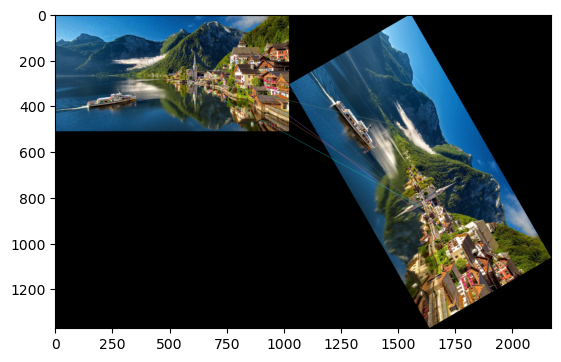

(<matplotlib.image.AxesImage at 0x13d83a89a48>, None)

In [113]:
# Detect keypoints and compute descriptors for both images
kp1, descriptors1 = siftT2.detectAndCompute(imgNoise, None)
kp2, descriptors2 = siftT3.detectAndCompute(imgTransSIFT, None)

bf = cv2.BFMatcher()

# Use knnMatch to find the best matches
matches = bf.knnMatch(descriptors1, descriptors2, k = 2)

# Apply a ratio test to filter good matches
good_matches = []
ratio_threshold = 0.7  # Adjust the threshold as needed

for m,n in matches:
    if m.distance < ratio_threshold * n.distance:
        good_matches.append(m)

# Sort the matches by distance
top_matches = sorted(good_matches, key = lambda x:x.distance)

# Select the top 5 best matches
top_matches = good_matches[:5]


# cv.drawMatchesKnn expects list of lists as matches.
matched_image = cv2.drawMatches(imgNoise, kp1, imgTrans, kp2, top_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(matched_image),plt.show()

Although it is difficult to see, there are the top 5 matches SIFT keypoints. The fifth one is feint under the boat.